In [1]:
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import os
import sys

In [2]:
class Location:
    """Specify the locations of inputs and outputs"""

    # Get the path of the directory containing the script file
    script_dir = os.path.dirname(os.path.abspath(sys.path[0]))

    # Navigate up to the top-level directory
    src_level_dir = os.path.dirname(script_dir)

    top_level_dir = os.path.dirname(src_level_dir)

    # Define the relative path to the data directory
    data_dir = os.path.join(top_level_dir, "AutomatingAnalysisModelsAndMisprediction\\data")

    data_raw: str = f"{data_dir}\\raw\\creditcard.csv"
    data_process: str = f"{data_dir}\\processed\\creditcard.pkl"
    
    
class ProcessConfig:
    """Specify the parameters of the `process` flow"""

    label: str = "Class"
    test_size: float = 0.2

In [3]:
import pandas as pd
import pickle
def getProcessedData(file_path: str):
    # read python dict back from the file
    with open(file_path, 'rb') as f:
        split_dict = pickle.load(f)

    X_train = split_dict["X_train"]
    X_test = split_dict["X_test"]
    y_train = split_dict["y_train"]
    y_test = split_dict["y_test"]
    return X_train, X_test, y_train, y_test

def getUnprocessedData(url: str):
    dataset = pd.read_csv(url)
    return dataset

In [4]:
X_train, X_test, Y_train, Y_test = getProcessedData(Location.data_process)

In [5]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Init an H2O cluster
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Microsoft-25199 (build 11.0.12+7, mixed mode)
  Starting server from C:\Python311\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ADMINI~1\AppData\Local\Temp\tmpmcn4xwxx
  JVM stdout: C:\Users\ADMINI~1\AppData\Local\Temp\tmpmcn4xwxx\h2o_Administrator_started_from_python.out
  JVM stderr: C:\Users\ADMINI~1\AppData\Local\Temp\tmpmcn4xwxx\h2o_Administrator_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,14 secs
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_Administrator_q4hx68
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.945 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [8]:
# Convert training data to H2OFrame
dataset = getUnprocessedData(Location.data_raw)
train = h2o.H2OFrame(np.concatenate((X_train, Y_train.values.reshape(-1, 1)), axis=1))
train.columns = list(dataset.columns)
train[ProcessConfig.label] = train[ProcessConfig.label].asfactor()

# Specify target variable and predictor variables
x = train.columns[:-1]
y = train.columns[-1]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [9]:
# Run H2O AutoML to automatically select, train and optimize SVM model
print("Run H2O AutoML to automatically select, train and optimize SVM model")
# aml = H2OAutoML(max_models=10, seed=1)
aml = H2OAutoML(sort_metric='mse', max_runtime_secs=5 * 60, seed=666)
aml.train(x=x, y=y, training_frame=train)

Run H2O AutoML to automatically select, train and optimize SVM model
AutoML progress: |
19:03:38.520: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_1_AutoML_3_20230223_190337


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  --------
Stacking strategy                     blending
Number of base models (used / total)  1/2
# GBM base models (used / total)      1/1
# GLM base models (used / total)      0/1
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    AUTO
Metalearner nfolds                    0
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 8.755424705583197e-07
RMSE: 0.0009357042644758651
LogLoss: 0.00019461421334922906
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 9873
Residual degrees of freedom: 9872
Null deviance: 13688.400889030501
Residual deviance: 3.843241485220565
AIC: 7.843241485220565

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9712916299408709
       0     1     Error    Rate
-----  ----  ----  -------  ------------
0      4894  0     0        (0.0/4894.0)
1      0     4980  0        (0.0/4980.0)
Total  4894  4980  0        (0.0/9874.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.971292     1         290
max f2                       0.971292     1         290
max f0point5                 0.971292     1         290
max accuracy                 0.971292     1         290
max precision                0.999978     1         0
max recall                   0.971292     1         290
max specificity              0.999978     1         0
max absolute_mcc             0.971292     1         290
max min_per_class_accuracy   0.971292     1         290
max mean_per_class_accuracy  0.971292     1         290
max tns                      0.999978     4894      0
max fns                      0.999978     4928      0
max fps                      6.27431e-06  4894      399
max tps                      0.971292     4980      290
max tnr                      0.999978     1         0
max fnr                      0.999978     0.989558  0
max fpr                      6.27431e-06  1         399
max tpr                      0.971292     1         290

Gains/Lift Table: Avg response rate: 50.44 %, avg score: 50.42 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0100263                   0.999976           1.98273    1.98273            1                0.999978     1                           0.999978            0.0198795       0.0198795                  98.2731  98.2731            0.0198795
2        0.0200527                   0.999975           1.98273    1.98273            1                0.999976     1                           0.999977            0.0198795       0.039759                   98.2731  98.2731            0.039759
3        0.0301803                   0.999974           1.98273    1.98273            1                0.999975     1                           0.999976            0.0200803       0.0598394                  98.2731  98.2731            0.0598394
4        0.0400041                   0.999974           1.98273    1.98273            1                0.999974     1                           0.999976            0.0194779       0.0793173                  98.2731  98.2731            0.0793173
5        0.0500

In [10]:
# View the leaderboard of trained models
lb = aml.leaderboard
print(lb.head())

model_id                                                         mse       auc      logloss     aucpr    mean_per_class_error        rmse
StackedEnsemble_BestOfFamily_1_AutoML_3_20230223_190337  5.66727e-05  0.999997  0.000468833  0.999996             2.18646e-05  0.00752813
StackedEnsemble_BestOfFamily_2_AutoML_3_20230223_190337  6.06309e-05  0.999998  0.000501439  0.999997             2.18646e-05  0.00778659
GBM_1_AutoML_3_20230223_190337                           8.52133e-05  0.999997  0.000441627  0.999996             2.18646e-05  0.00923111
StackedEnsemble_AllModels_1_AutoML_3_20230223_190337     0.000278773  0.999998  0.00692152   0.999998             2.18646e-05  0.0166965
DRF_1_AutoML_3_20230223_190337                           0.000512066  0.999999  0.0041596    0.999999             0.000131451  0.0226289
GBM_2_AutoML_3_20230223_190337                           0.0133431    0.999292  0.0981412    0.999341             0.00934543   0.115513
GBM_3_AutoML_3_20230223_190337        

In [11]:
# Use the best model to predict on test data
print("Use the best model to predict on test data")
model = aml.leader
X_h2o = h2o.H2OFrame(X_test)
X_h2o.columns = list(dataset.columns)[:-1]
y_pred = model.predict(X_h2o).as_data_frame().values.flatten()

Use the best model to predict on test data
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [15]:
# Train a PySVM SVM model
print("Train a PySVM SVM model")
model = LinearSVC(random_state=0, tol=1e-5, max_iter=10000, dual=False)
model.fit(X_train, Y_train)

Train a PySVM SVM model


LinearSVC(dual=False, max_iter=10000, random_state=0, tol=1e-05)

In [16]:
# Test the model on the test data
y_pred = model.predict(X_test)
misclassified = np.where(Y_test != y_pred)[0]
print("Indices of potentially misclassified instances: ", misclassified)

Indices of potentially misclassified instances:  [    87    143    265 ... 113422 113570 113706]


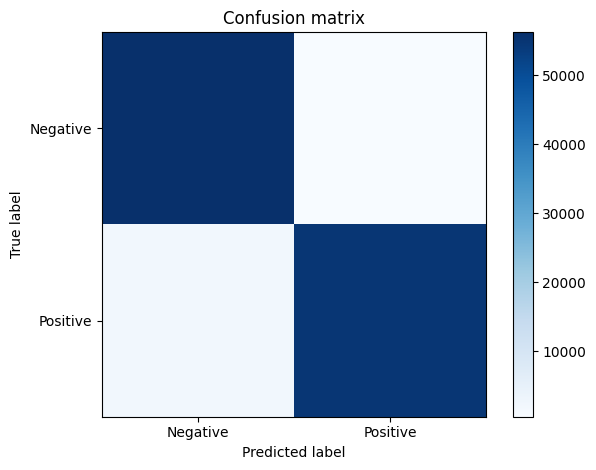

In [17]:
# Confusion matrix - summarizing the performance of a classification algorithm.
cm = confusion_matrix(Y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
plt.tight_layout()
plt.show()

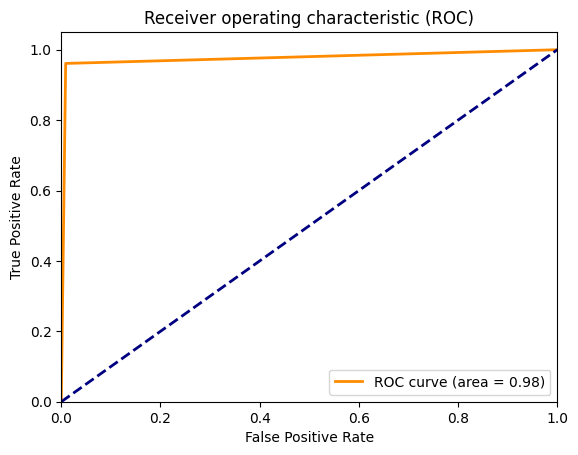

In [18]:
# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()